<a href="https://colab.research.google.com/github/sudeep-009/Retail-Sales-Prediction/blob/dev/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
rossmann_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/Rossmann Stores Data.csv')

In [5]:
store_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/store.csv')


###**Exploratory Data Analysis**

###Rossmann Stores Data
Lets first inspect the dataset here the main steps would be:
1.  Going through the first 5 and bottom 5 rows of the dataset.
2.  Finding out number of features and number of records present in the dataset.
3.  Features names present in the dataset.
2.  Finding out nulls present in the dataset.
3.  Finding the outlier present.
4.  Understanding the distribution of variables present in the dataset.
5.  Finding out the categorical and numerical variable present in the dateset.

**Going through first 5 and bottom 5 rows of the dataset**

In [6]:
pd.concat([rossmann_df.head(),rossmann_df.tail()])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


**Number of features and number of records present in the dataset**

In [7]:
print('Number of records present in the dataset is {}'.format(rossmann_df.shape[0]))
print('Number of features present in the dataset is {}'.format(rossmann_df.shape[1]))

Number of records present in the dataset is 1017209
Number of features present in the dataset is 9


**Checking for duplicated items present in the dataset**

In [34]:
print('Number of  duplicate items present in the dataset is {}'.format(len(rossmann_df[rossmann_df.duplicated()])))

Number of  duplicate items present in the dataset is 0


**Datatype of columns present in the dataset**

In [8]:
rossmann_df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

**Findings:** Date and StateHoliday is of categorical type

**Unique Element present in columns like DayofWeek, Open, Promo, StateHoliday, SchoolHoliday**

In [9]:
columns = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
for i in columns:
  print('Unique elements present in feature {} are {}'.format(i,rossmann_df[i].unique()))

Unique elements present in feature DayOfWeek are [5 4 3 2 1 7 6]
Unique elements present in feature Open are [1 0]
Unique elements present in feature Promo are [1 0]
Unique elements present in feature StateHoliday are ['0' 'a' 'b' 'c' 0]
Unique elements present in feature SchoolHoliday are [1 0]


**Findings:** We can treat the above features as categorical in nature

**Features name present in the dataset**

In [10]:
for i in rossmann_df.columns:
  print(i)

Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday


**Finding out nulls present in the dataset**

In [11]:
print('Count of Nulls present in the dataset are as follows')
rossmann_df.isnull().sum()

Count of Nulls present in the dataset are as follows


Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

**Findings:** There is no null value present in the dataset.

Creating another feature for Sales per Customer for each day for each Store present in the dataset as it will give us more clear understanding of the dataset.

In [12]:
rossmann_df['Sales/Customer'] = rossmann_df['Sales']/rossmann_df['Customers']

In [13]:
print('Count of Nulls present in the dataset are as follows')
rossmann_df.isnull().sum()

Count of Nulls present in the dataset are as follows


Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Sales/Customer    172869
dtype: int64

**Findings:** Here we see that Sales/Customer have lots of null values which is either due to zero Sales figure or zero Customer figure. So we will drop all those observation where there are null present for Sales/Customer.

In [14]:
rossmann_df.dropna(subset=['Sales/Customer'],axis=0,inplace=True)

**Finding out distribution of the target variable i.e Sales**

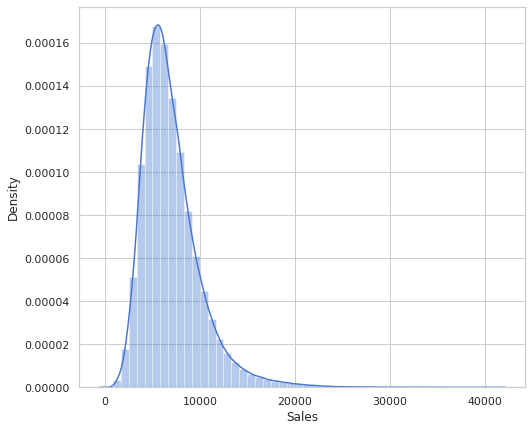

In [15]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(rossmann_df['Sales'])

**Finding:** Target Variable is almost normally distributed.

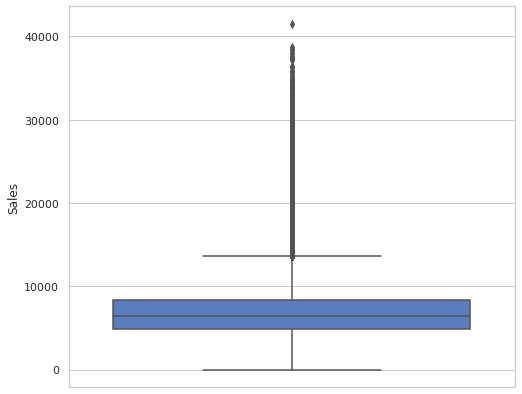

In [16]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.boxplot(y=rossmann_df['Sales'])

Removing Outlier present in the target variable

In [21]:
percentile_25 = np.percentile(rossmann_df['Sales'],25)
percentile_75 = np.percentile(rossmann_df['Sales'],75)
iqr = (percentile_75 - percentile_25)
outlier_values = percentile_75 + 1.5*iqr

In [30]:
rossmann_df.drop(index=rossmann_df[rossmann_df['Sales']>outlier_values].index,axis=0,inplace=True)

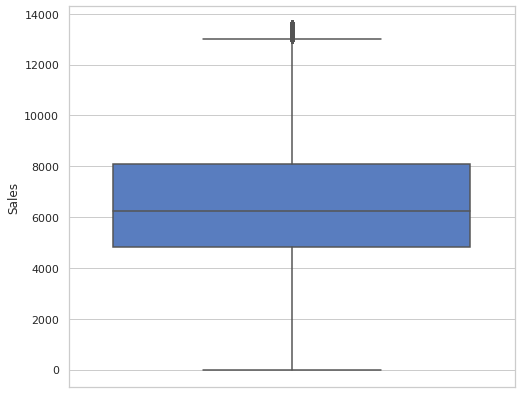

In [31]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.boxplot(y=rossmann_df['Sales'])

**Numerical features:** -- Custormers


**Categorical features:** -- dayOfWeek,StateHoliday,SchoolHoliday,Promo,date,Open

**Validating Linear Relationship between target variable and numerical features**

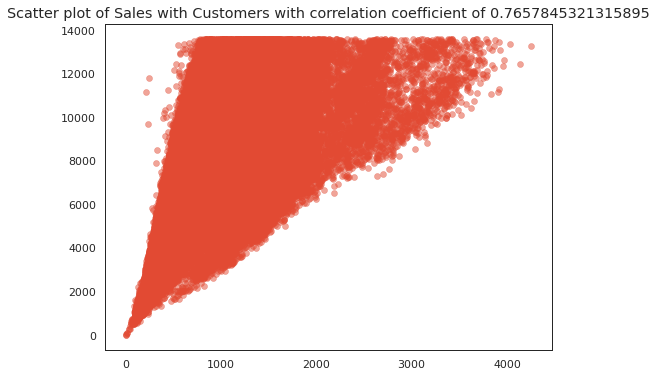

In [39]:
plt.scatter(rossmann_df['Customers'], rossmann_df['Sales'], alpha=0.5)
coeff,_=pearsonr(rossmann_df['Sales'],rossmann_df['Customers'])
plt.title('Scatter plot of Sales with Customers with correlation coefficient of {}'.format(coeff))
plt.show()


**Encoding feature StateHoliday such that 1 correspond to holiday and 0 correspond to none**

In [40]:
def isStateHoliday(x):
  if x == 'a' or x == 'b' or x == 'c':
    return 1
  else:
    return 0
rossmann_df['StateHoliday'] = rossmann_df['StateHoliday'].apply(lambda x: isStateHoliday(x))

In [41]:
rossmann_df['StateHoliday'].unique()

array([0, 1])

In [ ]:
rossmann_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Store                  1017209 non-null  int64 
 1   DayOfWeek              1017209 non-null  int64 
 2   Date                   1017209 non-null  object
 3   Sales                  1017209 non-null  int64 
 4   Customers              1017209 non-null  int64 
 5   Open                   1017209 non-null  int64 
 6   Promo                  1017209 non-null  int64 
 7   StateHoliday           1017209 non-null  object
 8   SchoolHoliday          1017209 non-null  int64 
 9   StateHoliday_modified  1017209 non-null  object
 10  isStateHoliday         1017209 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 85.4+ MB


In [ ]:
rossmann_df['isStateHoliday'].unique()

array([0, 1])

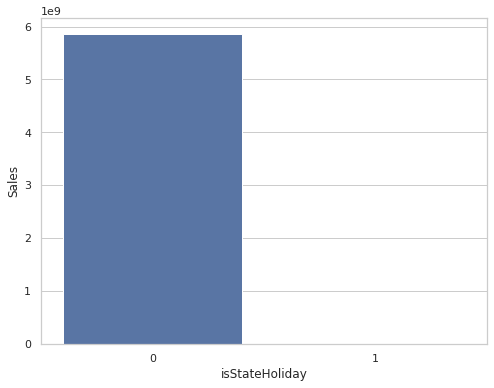

In [ ]:
sns.set_theme(style="whitegrid")
rossmann_plot_df = rossmann_df.groupby('isStateHoliday').agg({'Sales': 'sum'}).reset_index()
ax = sns.barplot(x=rossmann_plot_df.isStateHoliday, y=rossmann_plot_df.Sales)

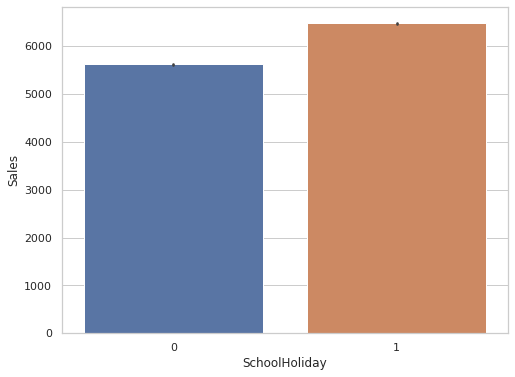

In [ ]:
ax = sns.barplot(x="SchoolHoliday", y="Sales", data=rossmann_df)

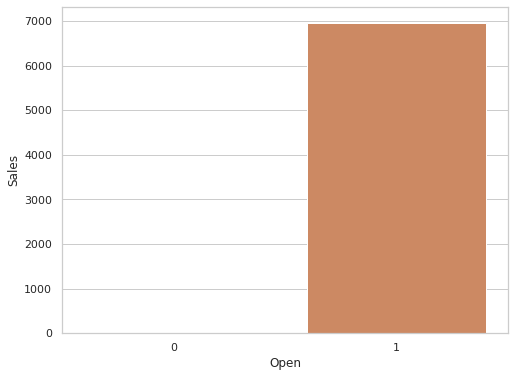

In [ ]:
ax = sns.barplot(x="Open", y="Sales", data=rossmann_df)

In [ ]:
ax = sns.barplot(x=rossmann_df.Promo, y=np.sum(rossmann_df.Sales))

AttributeError: ignored

In [ ]:
rossmann_df[rossmann_df['SchoolHoliday'] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
12,13,5,2015-07-31,8821,568,1,1,0,0
19,20,5,2015-07-31,9593,974,1,1,0,0
21,22,5,2015-07-31,6566,633,1,1,0,0
31,32,5,2015-07-31,6395,635,1,1,0,0
35,36,5,2015-07-31,12422,1251,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1014946,1082,4,2013-01-03,7303,1185,1,0,0,0
1014954,1090,4,2013-01-03,4607,689,1,0,0,0
1014957,1093,4,2013-01-03,8371,882,1,0,0,0
1014962,1098,4,2013-01-03,4591,675,1,0,0,0


In [ ]:
rossmann_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
rossmann_df['StateHoliday_modified'] = rossmann_df['StateHoliday'].apply(lambda x: str(x))
rossmann_df['StateHoliday_modified'] = rossmann_df['StateHoliday_modified'].apply(lambda x: x.strip())
rossmann_df['StateHoliday_modified'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday_modified, dtype: int64

In [ ]:
rossmann_df[rossmann_df['Open']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_modified
291,292,5,2015-07-31,0,0,0,1,0,1,0
875,876,5,2015-07-31,0,0,0,1,0,1,0
1406,292,4,2015-07-30,0,0,0,1,0,1,0
1990,876,4,2015-07-30,0,0,0,1,0,1,0
2521,292,3,2015-07-29,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a
1017205,1112,2,2013-01-01,0,0,0,0,a,1,a
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a


In [ ]:
rossmann_df.shape

(1017209, 9)

In [ ]:
rossmann_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
pd.concat([store_df.head(),store_df.tail()])

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
